**Last Done:** CNN functional (design choices still must be made) \\
**IPR:** fully connected model defn, combination of both models, training   

# Preliminary

In [1]:
!pip install torchinfo
!pip install --q huggingface_hub
!pip install --q transformers -U
!pip install --q sentencepiece

     |████████████████████████████████| 77 kB 3.0 MB/s 
     |████████████████████████████████| 4.0 MB 4.3 MB/s 
     |████████████████████████████████| 6.5 MB 25.1 MB/s 
     |████████████████████████████████| 895 kB 43.7 MB/s 
     |████████████████████████████████| 596 kB 55.3 MB/s 
     |████████████████████████████████| 1.2 MB 4.3 MB/s 


In [2]:
import numpy as np                  # just in case
import pandas as pd                 # for extracting info

import zipfile                      # for extracting photos from zip
from PIL import Image
from io import StringIO

import torch                                # machine learning packages
import torch.nn as nn               
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchinfo import summary 
import torchvision
import torchvision.transforms as transforms 
from torch.utils.tensorboard import SummaryWriter

from datetime import datetime               # utility and quality of life
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

In [3]:
torch.cuda.empty_cache()

## Parameters

In [4]:
# global variables 
img_size = 256              # assuming square images -> subject to change
img_channels = 3           # assuming RGB images 
num_outputs = 1             # we want a single number signifying the rating
batch_size = 128

# filepath = '/content/drive/MyDrive/EngSci Y3 Winter/YelpProject'    # this is the original filepath (vince)
filepath = '/content/drive/MyDrive/YelpProject'                             # use this for the shared account

# a small check to make sure the GPU is available:
# DISABLE IN COLAB WHEN NOT USING 
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Extraction

The Yelp Database (uploaded to Drive) is extracted to a pandas dataframe for input into the proposed neural networks shown below.

## Dataframe

In [6]:
yelp_data = pd.read_json(f'{filepath}/foodEntriesWithReviews.json')

In [7]:
yelp_data = yelp_data.dropna().reset_index()
yelp_data = yelp_data.head(1000)
yelp_data.head()

,index,photo_id,business_id,caption,label,rating,reviews
0,0,lZlulVObEzvCRhEmJAq-7A,2bncbx08BFs_IO6H-yWBxw,Dim sum! Turnip pancake,food,3.0,[[Chinatown is flush with Chinese restaurants ...
1,1,XvO6tewa1-gH20GIUtvQTA,qUY04I5gDm5uyInd1mCizg,"If you're into wicked good food\, go ahead.",food,4.0,[[the cutest place ever! We were visiting and ...
2,2,qTOGkJNCgdcD1GalYG6bZw,SAP7Myf72pKvEc54Zl45vQ,,food,3.5,[[I started looking this place up on yelp and ...
3,3,mwWW3GSErVOsSsR3GQ5CLg,VrlJifUE36-U_OaiipGexA,,food,4.0,[[This place is pretty good I would say. It di...
4,4,GyGbnJ9cwCe80fGYr9ZdRA,BujhETG-6POYdsi_8I_MBg,,food,3.5,"[[Really really hit the spot, dreaming of a go..."


## Text Reviews and Ratings

In [8]:
# taking a closer look at the text reviews:
yelp_data.iloc[8]['reviews']

[['If you are looking for a sweet treat at Harvard Square definitely stop into milk bar... This is one of our favorite shops when we visit New York City so we...',
  4],
 ["I don't understand what the hype is about. I got a slice of their apple cider doughnut cake. There were layers of hard frosting and spiced apple jam, and...",
  2],
 ["Don't understand the hype of this place. Got the crunchy cereal milk shake, it was boring and nothing special. The soft serve flavor of the month was funnel...",
  2]]

In [9]:
reviews = []
ratings = []

for block_review in yelp_data['reviews']:
    if block_review:
        for review in block_review:
            reviews.append(review[0])
            ratings.append(review[1])

reviews = np.array(reviews)         
ratings = np.array(ratings)

print(f'sample review: {reviews[0]}')
print(f'corresponding rating: {ratings[0]}')
print(f'number of reviews/ratings: {ratings.size}')

sample review: Chinatown is flush with Chinese restaurants densely packed on every block - most of which, in my opinion at least, have adapted strongly to the American...
corresponding rating: 4
number of reviews/ratings: 3000


## Images

In [10]:
zip_obj = zipfile.ZipFile(f'{filepath}/foodPhotos.zip', mode='r')
zip_obj.namelist()[0:5]                 # small look into our namelist

['foodPhotos/',
 'foodPhotos/-5zFb3OJT40b_y1y-OYm3g.jpg',
 '__MACOSX/foodPhotos/._-5zFb3OJT40b_y1y-OYm3g.jpg',
 'foodPhotos/3HCtnuCU-fAyedmUldVNNA.jpg',
 '__MACOSX/foodPhotos/._3HCtnuCU-fAyedmUldVNNA.jpg']

Here is a sample image


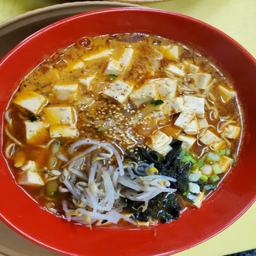

In [11]:
# a sample extraction
img_file = zip_obj.open(f'{zip_obj.namelist()[3]}')
img = Image.open(img_file)
img = img.resize((img_size, img_size))

print("Here is a sample image")
img

In [12]:
img_file.close()

In [13]:
# we can convert the image to numpy array -> tensor:
img_sample_tensor = torch.tensor(np.array(img)).to(device)
img_sample_tensor = img_sample_tensor.float()
img_sample_tensor = torch.permute(img_sample_tensor, (2, 0, 1))     # make channel dimension up front
img_sample_tensor = torch.unsqueeze(img_sample_tensor, 0)
img_sample_tensor.shape

torch.Size([1, 3, 256, 256])

## Complete Image Extraction

**NOTE:** This section is completely deprecated in favour of dataloaders (do NOT run!)

In [14]:
# # now to get all of the images
# yelp_imgs = []

# for id in yelp_data['photo_id']:
#     temp_path = f'{zip_obj.namelist()[0]}{id}.jpg'
#     img_file = zip_obj.open(temp_path)
#     img = Image.open(img_file)
#     img = img.resize((img_size, img_size))
#     yelp_imgs.append(img)

In [15]:
# yelp_imgs = np.array(yelp_imgs)
# print(yelp_imgs)

# Text Data Prep

## Tokenizer and Embedding Model

In this section, we declare our embedding model which will be used to train our image-to-embedding CNN. This is done using the `HuggingFace` package, which features a pretrained BERT model.

In [16]:
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-cased')

text_1 = "Who was Jim Henson ?"
text_2 = "Jim Henson was a puppeteer"

# Tokenized input with special tokens around it (for BERT: [CLS] at the beginning and [SEP] at the end)
indexed_tokens = tokenizer.encode(text_1, text_2, add_special_tokens=True)

Downloading: "https://github.com/huggingface/pytorch-transformers/archive/main.zip" to /root/.cache/torch/hub/main.zip


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

In [17]:
segments_ids = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]

# Convert inputs to PyTorch tensors
segments_tensors = torch.tensor([segments_ids])
tokens_tensor = torch.tensor([indexed_tokens])

# get our model
bert_model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'bert-base-cased')

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
# move our model to device
bert_model = bert_model.to(device)

In [19]:
data_extracted = np.array(yelp_data['reviews'].values)
for i in range(0, data_extracted.shape[0]):
    data_extracted[i] = np.array(data_extracted[i])

data_extracted = data_extracted.flatten()

In [20]:
# a sample tokenizer output:
test_token = tokenizer.encode(reviews[0], add_special_tokens=True)
token_tensor = torch.tensor([test_token]).to(device)

with torch.no_grad():
    test_embed = bert_model(token_tensor)[1]

print(f'Embedding vector produced with dimensionality: {test_embed.shape}')

Embedding vector produced with dimensionality: torch.Size([1, 768])


## Test/Train/Validation Splitting

In [21]:
reviews_train, reviews_test, ratings_train, ratings_test = train_test_split(reviews, ratings, test_size = 0.3)
reviews_test, reviews_valid, ratings_test, ratings_valid = train_test_split(reviews_test, ratings_test, test_size=0.33)

print(f'review train/test/valid sizes: {reviews_train.size}/{reviews_test.size}/{reviews_valid.size}')
print(f'review train/test/valid sizes: {ratings_train.size}/{ratings_test.size}/{ratings_valid.size}')

review train/test/valid sizes: 2100/603/297
review train/test/valid sizes: 2100/603/297


## Text Embedding Dataloaders

Pytorch's DataLoaders let us define large datasets that can be processed from files as inputs to our model. Data loading is GPU parallelizable, which is a necessity given the size of our dataset.

In [22]:
# now, we convert all text to embeddings as necessary:
# pytorch's dataloader class will handle parallelization for us
class embedding_data(Dataset):
    def __init__(self, tokenizer=None, model=None, reviews=None, ratings=None, device=device):
        self.tokenizer = tokenizer
        self.model = model
        self.reviews = reviews
        self.ratings = ratings

    def __len__(self):
        return self.reviews.size

    def __getitem__(self, idx):
        token = self.tokenizer.encode(self.reviews[idx], add_special_tokens=True)
        token_tensor = torch.tensor([token]).to(device)

        with torch.no_grad():
            embed = self.model(token_tensor)[1].flatten()

        rating = ratings[idx]

        return embed, rating

In [23]:
bert_data_train = embedding_data(tokenizer, bert_model, reviews_train)
bert_data_test = embedding_data(tokenizer, bert_model, reviews_test)
bert_data_valid = embedding_data(tokenizer, bert_model, reviews_valid)
print(f'This is a dataset entry dimension: {len(bert_data_train[0])}\n')

bert_loader_train = DataLoader(bert_data_train, batch_size=batch_size)
bert_loader_test = DataLoader(bert_data_test, batch_size=batch_size)
bert_loader_valid = DataLoader(bert_data_valid, batch_size=batch_size)
sample_bert_iterator = iter(bert_loader_train)

# a sample of our embedding loader (by iterating through it)
temp = next(sample_bert_iterator)
print(f'This is the dimensionality of a dataloader batch: {len(temp)}')
print(temp)
print(next(sample_bert_iterator))

This is a dataset entry dimension: 2

This is the dimensionality of a dataloader batch: 2
[tensor([[-0.7595,  0.4617,  0.9998,  ...,  0.9999, -0.6509,  0.9881],
        [-0.6540,  0.3978,  0.9995,  ...,  0.9998, -0.7915,  0.9711],
        [-0.7643,  0.4411,  0.9998,  ...,  0.9999, -0.8025,  0.9867],
        ...,
        [-0.6719,  0.4235,  0.9996,  ...,  0.9999, -0.8604,  0.9790],
        [-0.6938,  0.3995,  0.9993,  ...,  0.9997, -0.8163,  0.9699],
        [-0.6862,  0.4121,  0.9997,  ...,  0.9999, -0.7612,  0.9830]],
       device='cuda:0'), tensor([4, 4, 3, 5, 4, 3, 4, 3, 1, 4, 1, 3, 4, 3, 5, 4, 4, 3, 3, 5, 4, 4, 1, 5,
        4, 2, 2, 5, 4, 4, 5, 4, 4, 2, 5, 1, 2, 4, 4, 5, 5, 4, 5, 5, 5, 5, 5, 5,
        5, 2, 4, 5, 5, 5, 3, 2, 1, 5, 4, 4, 5, 4, 4, 5, 5, 5, 5, 2, 3, 5, 2, 3,
        5, 1, 4, 5, 1, 1, 4, 5, 2, 3, 1, 1, 5, 4, 5, 5, 5, 5, 5, 4, 5, 5, 4, 5,
        5, 3, 4, 4, 2, 3, 5, 1, 3, 4, 4, 4, 5, 3, 5, 5, 4, 5, 4, 1, 5, 4, 4, 3,
        5, 4, 1, 4, 1, 1, 5, 4])]
[tensor([[-0.765

In [24]:
# note that at any time we can go back to the start be redeclaring the iterator
sample_bert_iterator = iter(bert_loader_train)
print(next(sample_bert_iterator))

[tensor([[-0.7595,  0.4617,  0.9998,  ...,  0.9999, -0.6509,  0.9881],
        [-0.6540,  0.3978,  0.9995,  ...,  0.9998, -0.7915,  0.9711],
        [-0.7643,  0.4411,  0.9998,  ...,  0.9999, -0.8025,  0.9867],
        ...,
        [-0.6719,  0.4235,  0.9996,  ...,  0.9999, -0.8604,  0.9790],
        [-0.6938,  0.3995,  0.9993,  ...,  0.9997, -0.8163,  0.9699],
        [-0.6862,  0.4121,  0.9997,  ...,  0.9999, -0.7612,  0.9830]],
       device='cuda:0'), tensor([4, 4, 3, 5, 4, 3, 4, 3, 1, 4, 1, 3, 4, 3, 5, 4, 4, 3, 3, 5, 4, 4, 1, 5,
        4, 2, 2, 5, 4, 4, 5, 4, 4, 2, 5, 1, 2, 4, 4, 5, 5, 4, 5, 5, 5, 5, 5, 5,
        5, 2, 4, 5, 5, 5, 3, 2, 1, 5, 4, 4, 5, 4, 4, 5, 5, 5, 5, 2, 3, 5, 2, 3,
        5, 1, 4, 5, 1, 1, 4, 5, 2, 3, 1, 1, 5, 4, 5, 5, 5, 5, 5, 4, 5, 5, 4, 5,
        5, 3, 4, 4, 2, 3, 5, 1, 3, 4, 4, 4, 5, 3, 5, 5, 4, 5, 4, 1, 5, 4, 4, 3,
        5, 4, 1, 4, 1, 1, 5, 4])]


# Image Data Prep

## Test/Train/Validation Splitting

In [25]:
df_train, df_test = train_test_split(yelp_data, test_size = 0.3)
df_test, df_valid = train_test_split(df_test, test_size=0.33)

df_test = df_test.reset_index()
df_valid = df_valid.reset_index()

df_train = df_train.reset_index()

print(f'review train/test/valid sizes: {len(df_train)}/{len(df_test)}/{len(df_valid)}')

review train/test/valid sizes: 700/201/99


In [26]:
df_valid.head()

,level_0,index,photo_id,business_id,caption,label,rating,reviews
0,606,610,xbRY_9sSd7-D2MhKIw7NoA,woobkwxMjFaZL1sFEggirA,,food,4.0,[[Bibibop on 5th Avenue has always been consis...
1,163,163,Y1n3f9WPec9zT1fKQ5OPrQ,bxt0Qa9VadcxsUjTCXI8tA,,food,3.5,[[Very nice! I had been wanting to try this p...
2,222,223,ytGBFXvakb-oC0HdF7swlw,tkNlG6eAuLKP0IIeL0FmpQ,(:,food,4.5,[[There is nothing quite like a delicious heal...
3,176,176,Ew7kzm1SVetbl3T33-EOTw,X3bKIX-3uk9970bNst49tA,,food,4.0,[[I appreciate Bijou and their workers all wea...
4,842,847,v0mlgJvDY9sV4EKd-P999w,XW3NB-c3pA0vsmsXAn2rkw,Coreanos Allston bulgogi quesadilla 10/2017,food,4.5,"[[Was pretty average and bland. Ordered tacos,..."


In [27]:
type(df_valid['reviews'].values[2])

list

## Image Training Dataloaders

In [28]:
# pytorch's dataloader class will handle parallelization for us
class img_data(Dataset):
    def __init__(self, df=None, zip_obj=None, tokenizer=None, model=None, img_size=img_size, device=device):
        self.df = df
        self.zip_obj = zip_obj
        self.device=device
        self.img_size = img_size
        self.tokenizer = tokenizer
        self.model = model

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get image
        img_id = self.df['photo_id'][idx]
        temp_path = f'{self.zip_obj.namelist()[0]}{img_id}.jpg'
        img_file = self.zip_obj.open(temp_path)
        img = Image.open(img_file)
        img = img.resize((self.img_size, self.img_size))

        img_sample_tensor = torch.tensor(np.array(img)).to(self.device)
        img_sample_tensor = img_sample_tensor.float()
        img_sample_tensor = torch.permute(img_sample_tensor, (2, 0, 1))     # make channel dimension up front

        # get reviews
        review_block = self.df['reviews'].values[idx]
        
        # get ratings 
        ratings_block = self.df['rating'].values[idx]

        # combine all reviews to get an overall rating
        review = ''
        for entry in review_block:
            review += entry[0]
            review += ' '

        token = self.tokenizer.encode(review, add_special_tokens=True)
        token_tensor = torch.tensor([token]).to(device)

        with torch.no_grad():
            embed = self.model(token_tensor)[1].flatten()

        img.close()
        img_file.close()

        return (img_sample_tensor, embed, ratings_block)

In [29]:
# here are our datasets
img_dataset_train = img_data(df_train, zip_obj, tokenizer, bert_model)
img_dataset_test = img_data(df_test, zip_obj, tokenizer, bert_model)
img_dataset_valid = img_data(df_valid, zip_obj, tokenizer, bert_model)

# we can index right into the directly as follows
sample_img, sample_embed, sample_ratings = img_dataset_train[2]
print(sample_img.shape)
print(sample_embed.shape)
print(sample_ratings)

torch.Size([3, 256, 256])
torch.Size([768])
3.5


In [30]:
img_loader_train = DataLoader(img_dataset_train, batch_size=batch_size)
img_loader_test = DataLoader(img_dataset_test, batch_size=batch_size)
img_loader_valid = DataLoader(img_dataset_valid, batch_size=batch_size)

temp = next(iter(img_loader_train))
print(temp[0].shape)
print(temp[1].shape)

torch.Size([128, 3, 256, 256])
torch.Size([128, 768])


# Architectures

## Master Parameters

In [31]:
# set parameters here:
conv1_kernel_size = 11
conv2_kernel_size = 5
conv1_features = 20
conv2_features = 30
stride1 = 4
stride2 = 2
pool_kernel_size = 5
embedding_size = 768
hidden_ff_size = 50

## Image-to-Sentiment CNN

In [32]:
# as a preliminary, we start with a basic CNN with pooling (will be subject to change)

class simple_CNN(nn.Module):
    def __init__(self, conv1_kernel_size, conv2_kernel_size, stride1, stride2, 
                 conv1_features, conv2_features, 
                 pool_kernel_size, embedding_size):
                 
        super(simple_CNN, self).__init__()
        # some parameters:
        self.conv1_kernel_size = conv1_kernel_size   
        self.conv2_kernel_size = conv2_kernel_size
        self.conv1_features = conv1_features
        self.conv2_features = conv2_features
        self.stride1 = stride1
        self.stride2 = stride2
        self.pool_kernel_size = pool_kernel_size
        self.embedding_size = embedding_size
        self.img_channels = 3

        # the actual layers:
        self.conv1 = nn.Conv2d(self.img_channels, self.conv1_features, self.conv1_kernel_size)
        self.pool1 = nn.MaxPool2d(pool_kernel_size)
        self.norm1 = nn.BatchNorm2d(self.conv1_features)

        self.conv2 = nn.Conv2d(self.conv1_features, self.conv2_features, self.conv2_kernel_size)
        self.pool2 = nn.MaxPool2d(self.pool_kernel_size)
        self.norm2 = nn.BatchNorm2d(self.conv2_features)

        self.fc1 = nn.Linear(2430, 3000)
        self.fc2 = nn.Linear(3000, 1500)
        self.fc3 = nn.Linear(1500, self.embedding_size)

    def init_weights(self):
        '''
        initialize the layers (actual initializations are TBD)
        Linear initialization: uniform or Xavier might work here
        Conv initialization: Kaiming since we're using relu? literature says it's more effective
        '''
        torch.nn.init.kaiming_normal_(self.conv1.weight)
        torch.nn.init.kaiming_normal_(self.conv2.weight)
        torch.nn.init.xavier_normal_(self.fc1.weight)        
        torch.nn.init.xavier_normal_(self.fc2.weight)                
        torch.nn.init.xavier_normal_(self.fc3.weight)                


    def forward(self, x):
        x = self.conv1(x).to(device)       # each conv layer consists of convolution -> activation func -> pooling
        x = self.pool1(F.relu(self.norm1(x)))

        x = self.conv2(x)
        x = self.pool2(F.relu(self.norm2(x)))

        x = x.view(-1, self.num_flat_features(x))                    # to feed into linear layers
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.tanh(self.fc3(x))  
        # x = self.fc1(x)
        # x = self.fc2(x)
        # x = torch.tanh(self.fc3(x))    

        return x      

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [33]:
my_CNN = simple_CNN(conv1_kernel_size, conv2_kernel_size, stride1, stride2, 
                 conv1_features, conv2_features, 
                 pool_kernel_size, embedding_size).to(device)
summary(my_CNN, (1, 3, img_size, img_size))

Layer (type:depth-idx)                   Output Shape              Param #
simple_CNN                               --                        --
├─Conv2d: 1-1                            [1, 20, 246, 246]         7,280
├─BatchNorm2d: 1-2                       [1, 20, 246, 246]         40
├─MaxPool2d: 1-3                         [1, 20, 49, 49]           --
├─Conv2d: 1-4                            [1, 30, 45, 45]           15,030
├─BatchNorm2d: 1-5                       [1, 30, 45, 45]           60
├─MaxPool2d: 1-6                         [1, 30, 9, 9]             --
├─Linear: 1-7                            [1, 3000]                 7,293,000
├─Linear: 1-8                            [1, 1500]                 4,501,500
├─Linear: 1-9                            [1, 768]                  1,152,768
Total params: 12,969,678
Trainable params: 12,969,678
Non-trainable params: 0
Total mult-adds (M): 483.94
Input size (MB): 0.79
Forward/backward pass size (MB): 20.38
Params size (MB): 51.88
Estima

In [34]:
my_CNN.init_weights()
test = my_CNN(img_sample_tensor)
print(test[0][0:10])
print(test.shape)

tensor([-0.3140, -0.0598,  0.4092, -0.0669, -0.6544, -0.6740, -0.2546, -0.5855,
         0.5057,  0.5970], device='cuda:0', grad_fn=<SliceBackward0>)
torch.Size([1, 768])


## Sentiment-to-Rating NN

In [35]:
# this will take embedding vectors -> perform regression into a single 0-5 output
class linear_NN(nn.Module):
    def __init__(self, input_size, hidden_size):
            super(linear_NN, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            self.fc2 = torch.nn.Linear(self.hidden_size, 1)
            self.sigmoid = torch.nn.Sigmoid()               # do we want this to be multiplied by 5???
    
    def forward(self, x):
            hidden = self.fc1(x)
            relu = self.relu(hidden)
            output = self.fc2(relu)
            #output = self.sigmoid(output)
            return output.flatten()

    def init_weights(self):
        torch.nn.init.kaiming_normal_(self.fc1.weight)        # since we use relu here
        torch.nn.init.xavier_normal_(self.fc2.weight)          # since we use sigmoid here

In [36]:
# quick test:
temp_inp = torch.rand((768)).to(device)
temp_linear_model = linear_NN(768, 50).to(device)
temp_linear_model.init_weights()
temp_linear_model(temp_inp)

tensor([-0.2548], device='cuda:0', grad_fn=<AddBackward0>)

## Custom Embedding CNN

This notebook defines the components of a custom CNN architecture inspired by the semantic embedding to review prediction pipeline detailed by Tang et. al. After training the sentiment CNN and declaring our feed-forward network, all that's left is to connect the CNN output -> the feed-forward network. Training will be done on the two parts separately.

In [37]:
class embed_CNN(nn.Module):
    def __init__(self, conv1_kernel_size, conv2_kernel_size, stride1, stride2, 
                 conv1_features, conv2_features, 
                 pool_kernel_size, embedding_size, hidden_ff_size):
        super(embed_CNN, self).__init__()
        # store parameters for reference later:
        self.conv1_kernel_size = conv1_kernel_size
        self.conv2_kernel_size = conv2_kernel_size
        self.stride1 = stride1
        self.stride2 = stride2
        self.conv1_features = conv1_features
        self.conv2_features = conv2_features
        self.pool_kernel_size = pool_kernel_size
        self.embedding_size = embedding_size
        self.hidden_ff_size = hidden_ff_size

        # the two subarchitectures:
        self.CNN = simple_CNN(self.conv1_kernel_size, self.conv2_kernel_size, self.stride1, self.stride2, 
                 self.conv1_features, self.conv2_features, 
                 self.pool_kernel_size, self.embedding_size).to(device)
        self.linear = linear_NN(self.embedding_size, self.hidden_ff_size).to(device)

    def forward(self, x):
        x = self.CNN(x)
        x = self.linear(x)
        return x

    def CNN_forward(self, x):
        # for training purposes
        x  = self.CNN(x)
        return x

    def init_weights(self):
        self.CNN.init_weights()
        self.linear.init_weights()
        return 0

    def linear_forward(self, x):
        # for training purposes
        x = self.linear(x)
        return x

In [38]:
test_net = embed_CNN(conv1_kernel_size, conv2_kernel_size, stride1, stride2, 
                 conv1_features, conv2_features, 
                 pool_kernel_size, embedding_size, hidden_ff_size).to(device)

test_net.init_weights()
test_net(img_sample_tensor)

tensor([0.0429], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)

In [39]:
summary(test_net, (1, 3, img_size, img_size))

Layer (type:depth-idx)                   Output Shape              Param #
embed_CNN                                --                        --
├─simple_CNN: 1-1                        [1, 768]                  --
│    └─Conv2d: 2-1                       [1, 20, 246, 246]         7,280
│    └─MaxPool2d: 2-2                    --                        --
│    └─BatchNorm2d: 2-3                  [1, 20, 246, 246]         40
│    └─Conv2d: 2-4                       --                        (recursive)
│    └─MaxPool2d: 2-5                    [1, 20, 49, 49]           --
│    └─Conv2d: 2-6                       [1, 30, 45, 45]           15,030
│    └─BatchNorm2d: 2-7                  [1, 30, 45, 45]           60
│    └─MaxPool2d: 2-8                    [1, 30, 9, 9]             --
│    └─Linear: 2-9                       [1, 3000]                 7,293,000
│    └─Linear: 2-10                      [1, 1500]                 4,501,500
│    └─Linear: 2-11                      [1, 768]      

In [40]:
#USE TO LOAD IN SAVED MODELS
loaded_linear = torch.load('/content/drive/MyDrive/YelpProject/Final Architectures/second_half_model')
test_net.linear.load_state_dict(loaded_linear, strict=False)

<All keys matched successfully>

# Training

## OLD

In [41]:
# def trainloop(model, optimizer, iter_train, iter_results, loss_fn):
#     for train_batch, result_batch in iter_train, iter_results:
#         optimizer.zerograd()

#         # loss
#         batch_loss = loss_fn(model(train_batch), result_batch)

#         # backwards call
#         batch_loss.backwards()
        
#         # opt step
#         optimizer.step()

In [42]:
# for i, data in enumerate(img_loader_train):
#     inputs, labels = data
#     labels = labels.to(device)
#     print(labels)

## Embedding to Rating Training

In [43]:
def train_one_epoch(epoch_index, tb_writer, optimizer, model, loss_fn):
    running_loss = 0.
    last_loss = 0.
    loss_list = []

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(bert_loader_train):
        print("batch", i)
        # Every data instance is an input + label pair
        bert_batch, rating_batch = data
        bert_batch = bert_batch.to(device)
        rating_batch = rating_batch.to(device).float()

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(bert_batch).to(device)
        print(outputs[0])

        # Compute the loss and its gradients
        loss = loss_fn(outputs, rating_batch)

        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        # if i+1 % 100 == 0:
        #     last_loss = running_loss / 1000 # loss per batch
        #     print('  batch {} loss: {}'.format(i + 1, last_loss))
        #     tb_x = epoch_index * len(bert_loader_train) + i + 1
        #     tb_writer.add_scalar('Loss/train', last_loss, tb_x)
        #     running_loss = 0.

        loss_list.append(loss.item())

    loss_list = np.array(loss_list)
    loss_overall = np.sum(loss_list)/loss_list.size
    return loss_overall

In [44]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

optimizer = torch.optim.Adam(test_net.linear.parameters(),lr = 0.01)
loss_fn = torch.nn.MSELoss()

epoch_number = 0
EPOCHS = 5
best_vloss = float('inf')

lin_loss_arr = np.zeros(EPOCHS)

for epoch in tqdm(range(int(EPOCHS)),desc="Training Epochs"):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    test_net.linear.train(True)
    
    lin_loss = train_one_epoch(epoch_number, writer, optimizer, test_net.linear,loss_fn)
    lin_loss_arr[epoch_number] = lin_loss

    # We don't need gradients on to do reporting
    test_net.linear.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(bert_loader_test):
        vinputs, vlabels = vdata
        vlabels = vlabels.to(device)
        voutputs = test_net.linear(vinputs).to(device)
        vloss = loss_fn(voutputs, vlabels).to(device)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} test {}'.format(lin_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Test Loss',
                    { 'Training' : lin_loss, 'Test' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'linmodel_{}_{}'.format(timestamp, epoch_number)
        torch.save(test_net.linear.state_dict(), model_path)

    epoch_number += 1
    torch.cuda.empty_cache()

Training Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

EPOCH 1:
batch 0
tensor(0.7889, device='cuda:0', grad_fn=<SelectBackward0>)
batch 1
tensor(1.3347, device='cuda:0', grad_fn=<SelectBackward0>)
batch 2
tensor(1.9685, device='cuda:0', grad_fn=<SelectBackward0>)
batch 3
tensor(2.6879, device='cuda:0', grad_fn=<SelectBackward0>)
batch 4
tensor(3.5881, device='cuda:0', grad_fn=<SelectBackward0>)
batch 5
tensor(4.4993, device='cuda:0', grad_fn=<SelectBackward0>)
batch 6
tensor(5.0563, device='cuda:0', grad_fn=<SelectBackward0>)
batch 7
tensor(5.4334, device='cuda:0', grad_fn=<SelectBackward0>)
batch 8
tensor(5.5370, device='cuda:0', grad_fn=<SelectBackward0>)
batch 9
tensor(5.1854, device='cuda:0', grad_fn=<SelectBackward0>)
batch 10
tensor(4.8892, device='cuda:0', grad_fn=<SelectBackward0>)
batch 11
tensor(4.5920, device='cuda:0', grad_fn=<SelectBackward0>)
batch 12
tensor(4.1900, device='cuda:0', grad_fn=<SelectBackward0>)
batch 13
tensor(3.7928, device='cuda:0', grad_fn=<SelectBackward0>)
batch 14
tensor(3.5975, device='cuda:0', grad_fn=

Training Epochs:  20%|██        | 1/5 [00:26<01:47, 26.98s/it]

LOSS train 3.3758080566630646 test 2.0271730422973633
EPOCH 2:
batch 0
tensor(3.1113, device='cuda:0', grad_fn=<SelectBackward0>)
batch 1
tensor(3.2183, device='cuda:0', grad_fn=<SelectBackward0>)
batch 2
tensor(3.3034, device='cuda:0', grad_fn=<SelectBackward0>)
batch 3
tensor(3.4256, device='cuda:0', grad_fn=<SelectBackward0>)
batch 4
tensor(3.6955, device='cuda:0', grad_fn=<SelectBackward0>)
batch 5
tensor(3.9584, device='cuda:0', grad_fn=<SelectBackward0>)
batch 6
tensor(4.0365, device='cuda:0', grad_fn=<SelectBackward0>)
batch 7
tensor(4.1989, device='cuda:0', grad_fn=<SelectBackward0>)
batch 8
tensor(4.4024, device='cuda:0', grad_fn=<SelectBackward0>)
batch 9
tensor(4.3608, device='cuda:0', grad_fn=<SelectBackward0>)
batch 10
tensor(4.4350, device='cuda:0', grad_fn=<SelectBackward0>)
batch 11
tensor(4.4759, device='cuda:0', grad_fn=<SelectBackward0>)
batch 12
tensor(4.3975, device='cuda:0', grad_fn=<SelectBackward0>)
batch 13
tensor(4.2247, device='cuda:0', grad_fn=<SelectBackwar

Training Epochs:  40%|████      | 2/5 [00:53<01:19, 26.64s/it]

LOSS train 1.6107532767688526 test 1.4052904844284058
EPOCH 3:
batch 0
tensor(3.7693, device='cuda:0', grad_fn=<SelectBackward0>)
batch 1
tensor(3.7989, device='cuda:0', grad_fn=<SelectBackward0>)
batch 2
tensor(3.7278, device='cuda:0', grad_fn=<SelectBackward0>)
batch 3
tensor(3.7194, device='cuda:0', grad_fn=<SelectBackward0>)
batch 4
tensor(3.8439, device='cuda:0', grad_fn=<SelectBackward0>)
batch 5
tensor(3.9544, device='cuda:0', grad_fn=<SelectBackward0>)
batch 6
tensor(3.8863, device='cuda:0', grad_fn=<SelectBackward0>)
batch 7
tensor(3.9142, device='cuda:0', grad_fn=<SelectBackward0>)
batch 8
tensor(4.0479, device='cuda:0', grad_fn=<SelectBackward0>)
batch 9
tensor(3.9910, device='cuda:0', grad_fn=<SelectBackward0>)
batch 10
tensor(4.0969, device='cuda:0', grad_fn=<SelectBackward0>)
batch 11
tensor(4.1701, device='cuda:0', grad_fn=<SelectBackward0>)
batch 12
tensor(4.1783, device='cuda:0', grad_fn=<SelectBackward0>)
batch 13
tensor(4.0891, device='cuda:0', grad_fn=<SelectBackwar

Training Epochs:  60%|██████    | 3/5 [01:19<00:52, 26.48s/it]

LOSS train 1.4553092087016386 test 1.392398715019226
EPOCH 4:
batch 0
tensor(3.9829, device='cuda:0', grad_fn=<SelectBackward0>)
batch 1
tensor(4.0314, device='cuda:0', grad_fn=<SelectBackward0>)
batch 2
tensor(3.9205, device='cuda:0', grad_fn=<SelectBackward0>)
batch 3
tensor(3.8975, device='cuda:0', grad_fn=<SelectBackward0>)
batch 4
tensor(3.9852, device='cuda:0', grad_fn=<SelectBackward0>)
batch 5
tensor(4.0435, device='cuda:0', grad_fn=<SelectBackward0>)
batch 6
tensor(3.9106, device='cuda:0', grad_fn=<SelectBackward0>)
batch 7
tensor(3.8679, device='cuda:0', grad_fn=<SelectBackward0>)
batch 8
tensor(3.9620, device='cuda:0', grad_fn=<SelectBackward0>)
batch 9
tensor(3.8825, device='cuda:0', grad_fn=<SelectBackward0>)
batch 10
tensor(3.9876, device='cuda:0', grad_fn=<SelectBackward0>)
batch 11
tensor(4.0506, device='cuda:0', grad_fn=<SelectBackward0>)
batch 12
tensor(4.0790, device='cuda:0', grad_fn=<SelectBackward0>)
batch 13
tensor(4.0086, device='cuda:0', grad_fn=<SelectBackward

Training Epochs:  80%|████████  | 4/5 [01:45<00:26, 26.36s/it]

LOSS train 1.4411166135002584 test 1.4057598114013672
EPOCH 5:
batch 0
tensor(4.0590, device='cuda:0', grad_fn=<SelectBackward0>)
batch 1
tensor(4.1116, device='cuda:0', grad_fn=<SelectBackward0>)
batch 2
tensor(3.9725, device='cuda:0', grad_fn=<SelectBackward0>)
batch 3
tensor(3.9484, device='cuda:0', grad_fn=<SelectBackward0>)
batch 4
tensor(4.0224, device='cuda:0', grad_fn=<SelectBackward0>)
batch 5
tensor(4.0608, device='cuda:0', grad_fn=<SelectBackward0>)
batch 6
tensor(3.9062, device='cuda:0', grad_fn=<SelectBackward0>)
batch 7
tensor(3.8373, device='cuda:0', grad_fn=<SelectBackward0>)
batch 8
tensor(3.9243, device='cuda:0', grad_fn=<SelectBackward0>)
batch 9
tensor(3.8483, device='cuda:0', grad_fn=<SelectBackward0>)
batch 10
tensor(3.9655, device='cuda:0', grad_fn=<SelectBackward0>)
batch 11
tensor(4.0288, device='cuda:0', grad_fn=<SelectBackward0>)
batch 12
tensor(4.0689, device='cuda:0', grad_fn=<SelectBackward0>)
batch 13
tensor(4.0024, device='cuda:0', grad_fn=<SelectBackwar

Training Epochs: 100%|██████████| 5/5 [02:12<00:00, 26.41s/it]

LOSS train 1.4428776502609253 test 1.4119389057159424


In [45]:
# model_path = 'linmodel_trained_0412.pt'
# torch.save(test_net.linear.state_dict(), model_path)

Text(0.5, 1.0, 'Embedding to Rating Cumulative Training Loss')

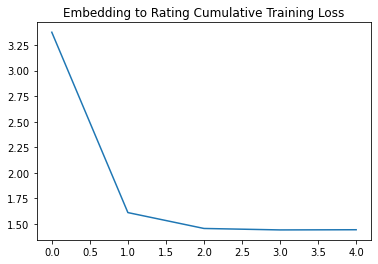

In [46]:
fig, ax = plt.subplots()
ax.plot(lin_loss_arr)
ax.set_title('Embedding to Rating Cumulative Training Loss')

## Image to Embedding Training

In [47]:
# DELETE THIS AFTER DEBUGGING (DO NOT RUN IT OTHERWISE)
test_net = embed_CNN(conv1_kernel_size, conv2_kernel_size, stride1, stride2, 
                 conv1_features, conv2_features, 
                 pool_kernel_size, embedding_size, hidden_ff_size).to(device)

test_net.init_weights()
test_net(img_sample_tensor)

tensor([-0.7426], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)

In [48]:
def train_one_epoch_CNN(epoch_index, tb_writer, optimizer, model, loss_fn):
    running_loss = 0.
    last_loss = 0.
    loss_list = []

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(img_loader_train):
        print("batch", i)
        # Every data instance is an input + label pair
        img_batch, bert_batch, dummy = data
        img_batch = img_batch.to(device)
        bert_batch = bert_batch.to(device).float()

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(img_batch).to(device)

        sampleidx = random.randint(0, 3)

        print(outputs[sampleidx][0:10])
        print(outputs[sampleidx+1][0:10])

        # Compute the loss and its gradients
        loss = loss_fn(outputs, bert_batch)

        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        # running_loss += loss.item()
        # if i+1 % 100 == 0:
        #     last_loss = running_loss / 1000 # loss per batch
        #     print('  batch {} loss: {}'.format(i + 1, last_loss))
        #     tb_x = epoch_index * len(img_loader_train) + i + 1
        #     tb_writer.add_scalar('Loss/train', last_loss, tb_x)
        #     running_loss = 0.

        loss_list.append(loss.item())

    loss_list = np.array(loss_list)
    loss_overall = np.sum(loss_list)/loss_list.size
    return loss_overall

In [49]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

optimizer = torch.optim.Adam(test_net.CNN.parameters(), lr = 0.00001)
loss_fn = torch.nn.MSELoss()

epoch_number = 0
EPOCHS = 5
best_vloss = float('inf')

loss_arr = np.zeros(EPOCHS)

for epoch in tqdm(range(int(EPOCHS)),desc="Training Epochs"):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    test_net.CNN.train(True)
    
    avg_loss = train_one_epoch_CNN(epoch_number, writer, optimizer, test_net.CNN,loss_fn)

    loss_arr[epoch_number] = avg_loss

    # We don't need gradients on to do reporting
    test_net.CNN.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(img_loader_test):
        vinputs, vlabels, dummy = vdata
        vlabels = vlabels.to(device)
        # vlabels = vlabels.to('cpu')
        voutputs = test_net.CNN(vinputs)
        vloss = loss_fn(voutputs, vlabels).to(device)
        running_vloss += vloss


    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} Test {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Test Loss',
                    { 'Training' : avg_loss, 'Test' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    # if avg_vloss < best_vloss:
    best_vloss = avg_vloss
    model_path = 'cnnmodel_{}_{}'.format(timestamp, epoch_number)
    torch.save(test_net.CNN.state_dict(), model_path)

    epoch_number += 1
    torch.cuda.empty_cache()



Training Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

EPOCH 1:
batch 0
tensor([ 0.6204, -0.0790, -0.3913,  0.7955, -0.0053,  0.3418, -0.5808, -0.1554,
        -0.4195,  0.5007], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([ 0.6404, -0.0995, -0.4219,  0.7675,  0.1112,  0.3786, -0.5268, -0.2059,
        -0.3959,  0.4793], device='cuda:0', grad_fn=<SliceBackward0>)
batch 1
tensor([ 0.6091, -0.0066, -0.3707,  0.7834, -0.0374,  0.3796, -0.5693, -0.1206,
        -0.4334,  0.4658], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([ 0.6087, -0.0158, -0.4070,  0.7493,  0.0566,  0.3459, -0.4345, -0.1821,
        -0.4025,  0.4861], device='cuda:0', grad_fn=<SliceBackward0>)
batch 2
tensor([ 0.6015, -0.0010, -0.3592,  0.7541,  0.0629,  0.3937, -0.5812, -0.2036,
        -0.4463,  0.4662], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([ 0.6308, -0.0388, -0.4509,  0.7461,  0.0825,  0.3458, -0.5755, -0.1809,
        -0.4160,  0.4071], device='cuda:0', grad_fn=<SliceBackward0>)
batch 3
tensor([ 0.5563,  0.0637, -0.3627,  0.7489,  0.1599,  0.354

Training Epochs:  20%|██        | 1/5 [00:32<02:08, 32.10s/it]

LOSS train 0.7961205939451853 Test 0.7346900701522827
EPOCH 2:
batch 0
tensor([ 0.5538,  0.0823, -0.3024,  0.7305,  0.0660,  0.4031, -0.5008, -0.2963,
        -0.4742,  0.4131], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([ 0.5784,  0.0517, -0.3346,  0.6972,  0.1822,  0.4378, -0.4463, -0.3362,
        -0.4477,  0.3911], device='cuda:0', grad_fn=<SliceBackward0>)
batch 1
tensor([ 0.5399,  0.1513, -0.2731,  0.7109,  0.0404,  0.4361, -0.4875, -0.2627,
        -0.4845,  0.3675], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([ 0.5376,  0.1430, -0.3152,  0.6701,  0.1314,  0.4104, -0.3374, -0.3253,
        -0.4534,  0.3917], device='cuda:0', grad_fn=<SliceBackward0>)
batch 2
tensor([ 0.5315,  0.1576, -0.2635,  0.6760,  0.1358,  0.4504, -0.4981, -0.3405,
        -0.4914,  0.3694], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([ 0.5661,  0.1105, -0.3657,  0.6702,  0.1510,  0.4093, -0.4966, -0.3122,
        -0.4622,  0.3091], device='cuda:0', grad_fn=<SliceBackward0>)
batch 3
tenso

Training Epochs:  40%|████      | 2/5 [00:57<01:23, 27.89s/it]

LOSS train 0.6909552911917368 Test 0.6329418420791626
EPOCH 3:
batch 0
tensor([ 0.4567,  0.2078, -0.2264,  0.6060,  0.1152,  0.4590, -0.4461, -0.3765,
        -0.5476,  0.3420], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([ 0.4786,  0.2211, -0.2050,  0.6421,  0.1330,  0.4473, -0.4002, -0.4251,
        -0.5177,  0.3091], device='cuda:0', grad_fn=<SliceBackward0>)
batch 1
tensor([ 0.5573,  0.2740, -0.2154,  0.5806,  0.1617,  0.3762, -0.2717, -0.4623,
        -0.5286,  0.3768], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([ 0.4660,  0.2463, -0.2489,  0.5436,  0.1344,  0.4659, -0.2987, -0.3571,
        -0.5029,  0.2093], device='cuda:0', grad_fn=<SliceBackward0>)
batch 2
tensor([ 0.3912,  0.2380, -0.1889,  0.6005,  0.1979,  0.4325, -0.3477, -0.4516,
        -0.4752,  0.2444], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([ 0.4701,  0.3487, -0.2017,  0.5983,  0.2242,  0.5054, -0.2993, -0.4184,
        -0.5262,  0.2251], device='cuda:0', grad_fn=<SliceBackward0>)
batch 3
tenso

Training Epochs:  60%|██████    | 3/5 [01:22<00:53, 26.70s/it]

LOSS train 0.5945429106553396 Test 0.5420894622802734
EPOCH 4:
batch 0
tensor([ 0.3727,  0.3115, -0.1229,  0.4873,  0.1818,  0.4887, -0.3325, -0.4813,
        -0.5798,  0.2204], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([ 0.3976,  0.3269, -0.1029,  0.5292,  0.1922,  0.4769, -0.2748, -0.5311,
        -0.5512,  0.1920], device='cuda:0', grad_fn=<SliceBackward0>)
batch 1
tensor([ 0.4859,  0.3660, -0.1115,  0.4506,  0.2165,  0.4106, -0.1446, -0.5566,
        -0.5619,  0.2697], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([ 0.3844,  0.3465, -0.1458,  0.4156,  0.1947,  0.5018, -0.1708, -0.4709,
        -0.5363,  0.0911], device='cuda:0', grad_fn=<SliceBackward0>)
batch 2
tensor([ 0.3119,  0.3321, -0.0850,  0.4798,  0.2575,  0.4660, -0.2209, -0.5478,
        -0.5062,  0.1222], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([ 0.3850,  0.4310, -0.1021,  0.4732,  0.2800,  0.5339, -0.1724, -0.5197,
        -0.5537,  0.0936], device='cuda:0', grad_fn=<SliceBackward0>)
batch 3
tenso

Training Epochs:  80%|████████  | 4/5 [01:47<00:25, 25.99s/it]

LOSS train 0.5082400043805441 Test 0.46212026476860046
EPOCH 5:
batch 0
tensor([ 0.2854,  0.3795, -0.0207,  0.3435,  0.2402,  0.5105, -0.2031, -0.5633,
        -0.6059,  0.0904], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([ 0.3104,  0.3978, -0.0018,  0.3904,  0.2444,  0.4972, -0.1351, -0.6126,
        -0.5779,  0.0669], device='cuda:0', grad_fn=<SliceBackward0>)
batch 1
tensor([ 0.2649,  0.4045, -0.0594,  0.2849,  0.3024,  0.4680, -0.0788, -0.6095,
        -0.5710, -0.0148], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([ 0.2932,  0.4400,  0.0523,  0.3315,  0.2358,  0.5243, -0.1172, -0.5867,
        -0.5823,  0.0040], device='cuda:0', grad_fn=<SliceBackward0>)
batch 2
tensor([ 0.2839,  0.4458,  0.0442,  0.3012,  0.3045,  0.5419, -0.1269, -0.6387,
        -0.5792,  0.0156], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([ 0.3299,  0.3898, -0.0674,  0.3087,  0.3165,  0.5194, -0.1380, -0.6023,
        -0.5565, -0.0422], device='cuda:0', grad_fn=<SliceBackward0>)
batch 3
tens

Training Epochs: 100%|██████████| 5/5 [02:12<00:00, 26.53s/it]

LOSS train 0.4323903371890386 Test 0.3924802541732788


Text(0.5, 1.0, 'Training Loss')

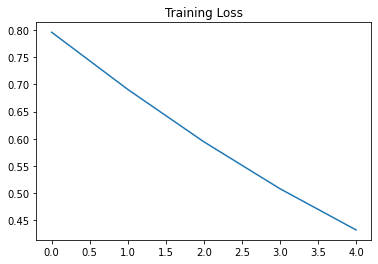

In [50]:
fig, ax = plt.subplots()
ax.plot(loss_arr)
ax.set_title('Training Loss')

voutputs[0][0:10]

In [ ]:
# voutputs[1].div_(torch.norm(voutputs[1],2))

In [ ]:
# voutputs[1].div_(torch.norm(voutputs[0],2))

## Results

In [ ]:
img_batch, rev_batch, rating_batch = next(iter(img_loader_valid))

In [ ]:
rating_batch = rating_batch.to(device)

In [ ]:
rating_pred = test_net(img_batch)
rating_pred

tensor([3.3072, 3.0928, 3.1431, 3.5075, 3.2103, 2.8054, 2.8313, 1.8102, 3.9317,
        3.1136, 3.7401, 3.0577, 3.4720, 3.5597, 3.1905, 3.3002, 2.7859, 3.2506,
        2.5313, 4.3226, 3.3222, 2.8805, 3.3544, 3.6632, 3.1045, 3.4903, 3.4259,
        3.2342, 3.1033, 3.5242, 2.6825, 3.6947, 2.5874, 3.6246, 3.0157, 3.4861,
        3.3814, 3.6821, 3.2858, 2.3824, 3.1015, 3.6546, 2.4544, 3.5709, 2.8096,
        2.9932, 3.3373, 3.0244, 3.8740, 2.8143, 3.3527, 4.1165, 3.7526, 3.1461,
        3.3645, 3.3839, 2.6540, 3.6089, 4.0751, 3.2035, 3.2861, 3.0823, 2.8698,
        3.6663, 3.0407, 2.6207, 2.5419, 2.5835, 3.6079, 3.0743, 3.3270, 3.5684,
        2.9287, 3.3482, 3.5812, 3.5613, 2.8538, 3.3109, 3.5787, 2.0983, 3.1610,
        3.4913, 3.4170, 3.4737, 3.2450, 2.6466, 2.9296, 2.8120, 3.3812, 3.2407,
        3.6655, 3.1367, 3.0429, 3.2365, 3.0328, 3.0906, 3.6563, 4.1477, 3.5061],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)

In [ ]:
a = rating_pred.to(device)
loss = nn.MSELoss()
loss_MSE = loss(a, rating_batch.to(device))

print(loss_MSE)

tensor(0.9547, device='cuda:0', dtype=torch.float64,
       grad_fn=<MseLossBackward0>)


In [ ]:
residuals = rating_pred - rating_batch
residuals = torch.absolute(residuals)
print(residuals)
# print(torch.mean(residuals**2))
percent_error = torch.mean(residuals/5)
acceptance_mask = residuals < 1
print(acceptance_mask)
loss_01 = torch.sum(acceptance_mask)/acceptance_mask.size(dim=0)
print(loss_01)

tensor([0.1928, 0.0928, 0.8569, 0.9925, 0.2897, 0.6946, 0.6687, 2.1898, 0.0683,
        1.3864, 0.7599, 0.9423, 0.5280, 0.4403, 0.3095, 0.1998, 2.2141, 0.2494,
        1.9687, 0.3226, 1.1778, 0.6195, 0.1456, 0.1632, 0.8955, 1.0097, 0.0741,
        1.2658, 0.3967, 0.0242, 0.8175, 0.8053, 1.9126, 0.8754, 0.9843, 1.0139,
        0.6186, 0.3179, 0.2858, 1.6176, 0.8985, 0.3454, 1.5456, 1.0709, 2.1904,
        1.0068, 0.6627, 1.4756, 0.6260, 1.1857, 0.6473, 0.1165, 0.7474, 0.8539,
        0.6355, 0.6161, 1.8460, 0.3911, 0.5751, 0.2965, 0.2139, 0.9177, 1.1302,
        0.8337, 1.4593, 1.3793, 0.9581, 1.4165, 0.1079, 0.9257, 0.6730, 0.4316,
        0.5713, 1.1518, 0.9188, 1.4387, 1.1462, 1.1891, 0.4213, 1.9017, 0.3390,
        1.0087, 0.5830, 0.5263, 0.2450, 0.8534, 1.5704, 1.1880, 0.1188, 0.2593,
        0.1655, 0.8633, 1.4571, 0.7635, 1.4672, 0.9094, 0.3437, 0.1477, 0.9939],
       device='cuda:0', dtype=torch.float64, grad_fn=<AbsBackward0>)
tensor([ True,  True,  True,  True,  True,  True, 